In [1]:
import uproot
from scipy.constants import epsilon_0, e as q_e
from matplotlib.colors import LogNorm
import matplotlib.colors as mcolors
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [23]:
def read_rootfile(file):
    #file = '00_iteration0_num5000.root' #'13_iteration5_from_num1000000.root'
    file_path = f"/storage/home/hcoda1/5/avira7/r-zjiang33-0/geant4_workdir/Grain-Charging-Simulations/build-sphere-charging/root/{file}"
    tree_name = "Hit Data"

    with uproot.open(file_path) as file:
        
        tree = file[tree_name]
        branch_names = tree.keys()
        branch_vars = {}
        for name in branch_names:
            branch_vars[name] = tree[name].array(library="np")

    df = pd.DataFrame(branch_vars)
    df['Kinetic_Energy_Diff_eV'] = (df['Kinetic_Energy_Pre_MeV'] - df['Kinetic_Energy_Post_MeV'])*1e6 # convert to eV

    df_lastevents = df.drop_duplicates(subset="Event_Number", keep="last")
    electrons_inside = df_lastevents[(df_lastevents["Volume_Name_Post"]=="G4_SILICON_DIOXIDE")&(df_lastevents["Particle_Type"]=="e-")]
    #electrons_outside = df_lastevents[(df_lastevents["Volume_Name_Post"]=="World")&(df_lastevents["Particle_Type"]=="e-")]

    return df, electrons_inside #, electrons_outside

In [ ]:
def plot_electron_positions(df,world_dimensions = (-0.05, 0.05), n_bins=100, iteration="iteration0"):

    # Define voxel edges
    x_edges = np.linspace(world_dimensions[0], world_dimensions[1], n_bins + 1)
    y_edges = np.linspace(world_dimensions[0], world_dimensions[1], n_bins + 1)
    z_edges = np.linspace(world_dimensions[0], world_dimensions[1], n_bins + 1)

    coords = np.vstack(df["Post_Step_Position_mm"])  # mm to m
    x, y, z = coords[:, 0], coords[:, 1], coords[:, 2]

    # Compute 3D histogram: sum of energy lost in each voxel
    hist_electrons, edges = np.histogramdd(
        np.column_stack((x, y, z)),
        bins=(x_edges, y_edges, z_edges)
    )

    # Get voxel centers for plotting
    x_centers = 0.5 * (x_edges[:-1] + x_edges[1:])
    y_centers = 0.5 * (y_edges[:-1] + y_edges[1:])
    z_centers = 0.5 * (z_edges[:-1] + z_edges[1:])
    X, Y, Z = np.meshgrid(x_centers, y_centers, z_centers, indexing='ij')

    # Mask nonzero voxels and flatten arrays for plotting
    mask = hist_electrons > 0
    Xf_electrons = X[mask]
    Yf_electrons = Y[mask]
    Zf_electrons = Z[mask]
    hist_values_electrons = hist_electrons[mask]

    # Plot
    fig = plt.figure(figsize=(8, 6))
    ax = fig.add_subplot(111, projection="3d")
    sc = ax.scatter(Xf_electrons, Yf_electrons, Zf_electrons, s=0.1, c=hist_values_electrons, cmap='viridis', norm=LogNorm(vmin=1, vmax=10), alpha=0.8)
    plt.colorbar(sc, ax=ax, label='')

    # Set sphere parameters
    radius = 0.05  # Adjust radius as needed
    # Create spherical coordinates
    u = np.linspace(0, 2 * np.pi, 100)
    v = np.linspace(0, np.pi, 100)
    sphere_x = radius * np.outer(np.cos(u), np.sin(v))
    sphere_y = radius * np.outer(np.sin(u), np.sin(v))
    sphere_z = radius * np.outer(np.ones_like(u), np.cos(v))
    ax.plot_surface(sphere_x, sphere_y, sphere_z, color='red', alpha=0.3, linewidth=0)
    ax.set_title(iteration)
    ax.set_aspect('equal')
    plt.show()

    return fig, ax 

In [32]:
def plot_potential_on_sphere(df, vmin=-0.07, vmax=0, iteration="iteration0"):

    coords_m = np.vstack(np.array(df["Post_Step_Position_mm"]))* 1e-3

    R = np.linalg.norm(coords_m, axis=1).max()

    n_theta = 200  # polar angle divisions
    n_phi = 400    # azimuthal divisions

    theta = np.linspace(0, np.pi, n_theta)
    phi = np.linspace(0, 2*np.pi, n_phi)
    theta_grid, phi_grid = np.meshgrid(theta, phi)

    x_s = R * np.sin(theta_grid) * np.cos(phi_grid)
    y_s = R * np.sin(theta_grid) * np.sin(phi_grid)
    z_s = R * np.cos(theta_grid)
    sphere_points = np.column_stack([x_s.ravel(), y_s.ravel(), z_s.ravel()])

    K = 1.0 / (4.0 * np.pi * epsilon_0 * 3.9)  # eps_r=3.9 for SiO2
    q = -q_e
    V_sphere = np.zeros(sphere_points.shape[0])

    for i, p in enumerate(sphere_points):
        r_vec = coords_m - p
        r = np.linalg.norm(r_vec, axis=1)
        V_sphere[i] = K * q * np.sum(1.0 / r)

    V_sphere_grid = V_sphere.reshape(theta_grid.shape)
    print(np.min(V_sphere_grid), np.max(V_sphere_grid))

    # Normalize colormap
    norm = mcolors.Normalize(vmin=vmin, vmax=vmax)
    facecolors = plt.cm.plasma(norm(V_sphere_grid))

    fig = plt.figure(figsize=(4, 6))
    ax = fig.add_subplot(111, projection='3d')
    surf = ax.plot_surface(
        x_s*1e3, y_s*1e3, z_s*1e3,  # back to mm for display
        facecolors=facecolors,  
        rstride=1, cstride=1, antialiased=False, shade=False
    )
    mappable = plt.cm.ScalarMappable(cmap='plasma', norm=norm)
    mappable.set_array(V_sphere_grid)
    fig.colorbar(mappable, ax=ax, shrink=0.5, aspect=20, label='Potential (V)',orientation='horizontal',pad=-0.1)
    ax.set_aspect('equal')
    ax.set_title(iteration)
    ax.set_axis_off()
    plt.show()

    return fig, ax 

# Iteration0 

-0.0765675410609561 -0.005960076295763736


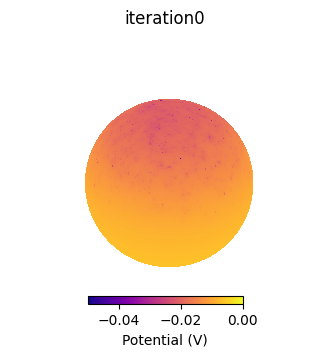

(<Figure size 400x600 with 2 Axes>, <Axes3D: title={'center': 'iteration0'}>)

In [33]:
# read data from different iterations
_, electrons_inside_iteration0 = read_rootfile("00_iteration0_num5000.root")

#plot_electron_positions(electrons_inside_iteration0, world_dimensions = (-0.05, 0.05), n_bins=100)
plot_potential_on_sphere(electrons_inside_iteration0, vmin=-0.05, vmax=0, iteration="iteration0")

# Iteration 1

-0.09374407501766827 -0.005722244666995073


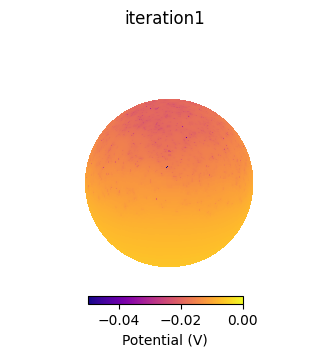

(<Figure size 400x600 with 2 Axes>, <Axes3D: title={'center': 'iteration1'}>)

In [34]:
# read data from different iterations
_, electrons_inside_iteration1 = read_rootfile("01_iteration1_from_00_num5000.root")

#plot_electron_positions(electrons_inside_iteration1, world_dimensions = (-0.05, 0.05), n_bins=100)
plot_potential_on_sphere(electrons_inside_iteration1, vmin=-0.05, vmax=0, iteration="iteration1")


# Iteration 2

-0.08594587445899839 -0.005945619568130005


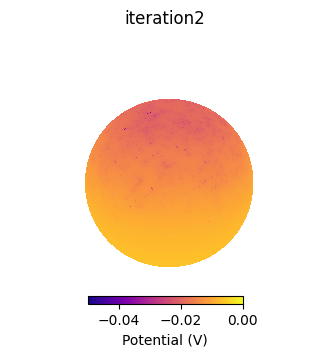

(<Figure size 400x600 with 2 Axes>, <Axes3D: title={'center': 'iteration2'}>)

In [35]:
# read data from different iterations
_, electrons_inside_iteration2 = read_rootfile("02_iteration2_from_00_num5000.root")

#plot_electron_positions(electrons_inside_iteration2, world_dimensions = (-0.05, 0.05), n_bins=100)
plot_potential_on_sphere(electrons_inside_iteration2, vmin=-0.05, vmax=0, iteration="iteration2")


# Iteration 3

-0.06079495675658088 -0.005620294496455831


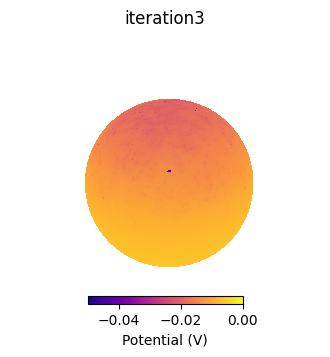

(<Figure size 400x600 with 2 Axes>, <Axes3D: title={'center': 'iteration3'}>)

In [36]:
# read data from different iterations
_, electrons_inside_iteration3 = read_rootfile("03_iteration3_from_00_num5000.root")

#plot_electron_positions(electrons_inside_iteration3, world_dimensions = (-0.05, 0.05), n_bins=100)
plot_potential_on_sphere(electrons_inside_iteration3, vmin=-0.05, vmax=0, iteration="iteration3")


In [ ]:
# ATTEMPTS TO MAKE THE CODE WORK FOR CARTESTIAN COORDINATES

# import numpy as np
# import matplotlib.pyplot as plt
# from scipy.constants import epsilon_0, e as q_e
# from matplotlib.colors import LogNorm

# # ----------------------------
# # 1. Electron positions
# # ----------------------------
# coords_m = np.vstack(np.array(electrons_inside_iteration0["Post_Step_Position_mm"])) * 1e-3  # mm to m

# # ----------------------------
# # 2. Define histogram grid
# # ----------------------------

# # Define voxel edges
# n_bins = 100
# world_dimensions = np.array([-0.05, 0.05])*1e-3  # convert mm to m
# x_edges = np.linspace(world_dimensions[0], world_dimensions[1], n_bins + 1)
# y_edges = np.linspace(world_dimensions[0], world_dimensions[1], n_bins + 1)
# z_edges = np.linspace(world_dimensions[0], world_dimensions[1], n_bins + 1)

# # Compute voxel centers
# x_centers = 0.5 * (x_edges[:-1] + x_edges[1:])
# y_centers = 0.5 * (y_edges[:-1] + y_edges[1:])
# z_centers = 0.5 * (z_edges[:-1] + z_edges[1:])
# X, Y, Z = np.meshgrid(x_centers, y_centers, z_centers, indexing='ij')

# voxel_centers = np.column_stack((X.ravel(), Y.ravel(), Z.ravel()))  # shape (N_voxels, 3)

# # ----------------------------
# # 3. Compute Electric Potential at Voxel Centers
# # ----------------------------
# K = 1.0 / (4.0 * np.pi * epsilon_0 * 3.9)  # SiO2 relative permittivity
# q = -q_e  # charge of an electron

# V_grid = np.zeros(voxel_centers.shape[0])

# for i, p in enumerate(voxel_centers):
#     r_vec = coords_m - p
#     r = np.linalg.norm(r_vec, axis=1)
#     V_grid[i] = K * q * np.sum(1.0 / r)

# V_grid_reshaped = V_grid.reshape(X.shape)  # same shape as the histogram

# # ----------------------------
# # 5. Plot Energy Loss with Potential Overlay (Optional)
# # ----------------------------
# # Mask nonzero energy loss
# mask = V_grid_reshaped > 0
# Xf = X[mask]
# Yf = Y[mask]
# Zf = Z[mask]
# V_values = V_grid_reshaped[mask]

# # Plot energy loss as 3D scatter with potential as color map
# fig = plt.figure(figsize=(10, 8))
# ax = fig.add_subplot(111, projection="3d")

# sc = ax.scatter(
#     Xf * 1e3, Yf * 1e3, Zf * 1e3,  # convert to mm
#     s=2,
#     c=V_values,
#     cmap='plasma',
#     norm=plt.Normalize(vmin=V_grid_reshaped.min(), vmax=V_grid_reshaped.max()),
#     alpha=0.9
# )

# cbar = plt.colorbar(sc, ax=ax, shrink=0.6, label='Electric Potential (V)')
# plt.tight_layout()
# plt.show()
